# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [106]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

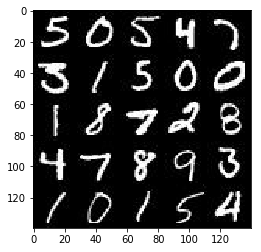

In [107]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

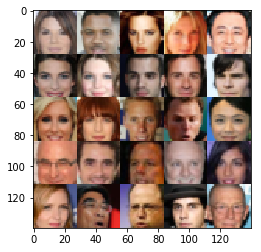

In [108]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [109]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [110]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None,image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [177]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)

        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)

        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        flat = tf.reshape(layer3, (-1, 4*4*256))
        flat = tf.nn.dropout(flat, 0.8)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [178]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # First fully connected layer
    with tf.variable_scope('generator', reuse=(not is_train)):
        layer1 = tf.layers.dense(z, 2*2*256)
        layer1 = tf.reshape(layer1, (-1, 2, 2, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2, padding='valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [179]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [180]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [181]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [182]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                batch_images = batch_images * 2
                z_batch = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: z_batch, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: z_batch, input_real: batch_images, learn_rate: learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: z_batch, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: z_batch})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3],data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.7336... Generator Loss: 0.1000
Epoch 1/2... Discriminator Loss: 1.8890... Generator Loss: 0.3125
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.2737
Epoch 1/2... Discriminator Loss: 1.5442... Generator Loss: 0.4598
Epoch 1/2... Discriminator Loss: 1.1045... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 5.5255... Generator Loss: 0.0076
Epoch 1/2... Discriminator Loss: 0.4249... Generator Loss: 1.7718
Epoch 1/2... Discriminator Loss: 2.3615... Generator Loss: 0.1515
Epoch 1/2... Discriminator Loss: 0.3672... Generator Loss: 1.5420
Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 2.5797


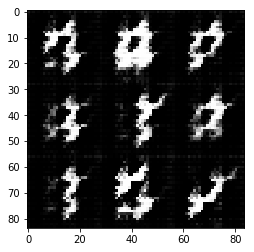

Epoch 1/2... Discriminator Loss: 0.7687... Generator Loss: 1.3815
Epoch 1/2... Discriminator Loss: 0.5196... Generator Loss: 1.8774
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 2.3185
Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 3.8617
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 1.3938
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 2.0537
Epoch 1/2... Discriminator Loss: 1.0152... Generator Loss: 2.8788
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 2.9560
Epoch 1/2... Discriminator Loss: 0.6135... Generator Loss: 1.7110
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 1.8139


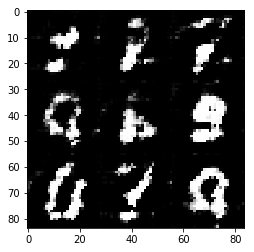

Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 2.0921
Epoch 1/2... Discriminator Loss: 2.2484... Generator Loss: 0.2361
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 0.5554
Epoch 1/2... Discriminator Loss: 0.7530... Generator Loss: 1.0684
Epoch 1/2... Discriminator Loss: 1.9074... Generator Loss: 0.2543
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 2.2630... Generator Loss: 0.2623
Epoch 1/2... Discriminator Loss: 0.8956... Generator Loss: 0.9601
Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 0.9164
Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 1.0663


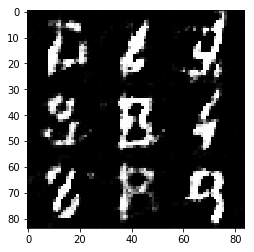

Epoch 1/2... Discriminator Loss: 1.8539... Generator Loss: 0.2589
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 1.7223
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 1.8966
Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 0.9497
Epoch 1/2... Discriminator Loss: 2.0780... Generator Loss: 0.2288
Epoch 1/2... Discriminator Loss: 0.9597... Generator Loss: 1.3882
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 1.4753
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 1.4016
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.7241


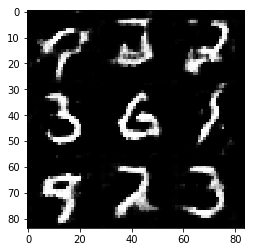

Epoch 1/2... Discriminator Loss: 1.2408... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 0.8972
Epoch 1/2... Discriminator Loss: 1.6736... Generator Loss: 3.0215
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 2.0105
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 1.3660
Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 1.5801
Epoch 2/2... Discriminator Loss: 1.5429... Generator Loss: 0.4342
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 2.3589
Epoch 2/2... Discriminator Loss: 1.4739... Generator Loss: 0.4419
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.6051


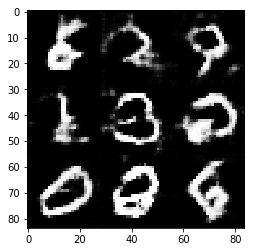

Epoch 2/2... Discriminator Loss: 0.9748... Generator Loss: 1.1123
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.4334
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 0.5484
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 1.3937
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 0.4749
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 0.6238
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 1.4930
Epoch 2/2... Discriminator Loss: 1.7314... Generator Loss: 1.7385
Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 0.5235
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 0.3852


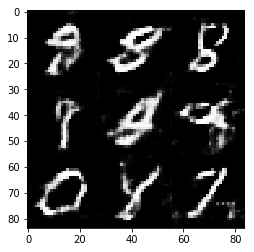

Epoch 2/2... Discriminator Loss: 1.1255... Generator Loss: 1.0379
Epoch 2/2... Discriminator Loss: 2.2570... Generator Loss: 2.4691
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 0.4760
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.4256
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 0.5648
Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 1.0427
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 1.1400
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 1.6638
Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 1.3078


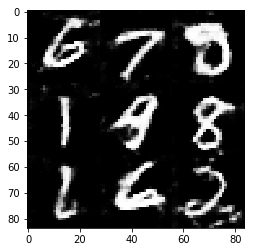

Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 1.0888
Epoch 2/2... Discriminator Loss: 1.4451... Generator Loss: 1.6739
Epoch 2/2... Discriminator Loss: 1.2939... Generator Loss: 0.5339
Epoch 2/2... Discriminator Loss: 2.1855... Generator Loss: 0.1821
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 0.6465
Epoch 2/2... Discriminator Loss: 1.0065... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 1.4987... Generator Loss: 0.4569
Epoch 2/2... Discriminator Loss: 1.4345... Generator Loss: 0.4108
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 1.1740
Epoch 2/2... Discriminator Loss: 1.1016... Generator Loss: 1.1198


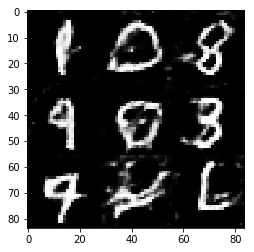

Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 0.4993
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 1.1664... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.6005
Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 0.6273
Epoch 2/2... Discriminator Loss: 1.4599... Generator Loss: 0.3999
Epoch 2/2... Discriminator Loss: 1.0961... Generator Loss: 1.3802
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 1.7304
Epoch 2/2... Discriminator Loss: 1.3258... Generator Loss: 0.4783
Epoch 2/2... Discriminator Loss: 1.5356... Generator Loss: 0.4111


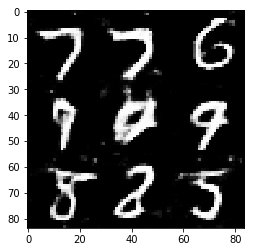

Epoch 2/2... Discriminator Loss: 1.0471... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 1.0885... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 1.2194


In [183]:
batch_size = 128
z_dim = 100
learning_rate = 0.005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 3.9247
Epoch 1/1... Discriminator Loss: 0.1700... Generator Loss: 2.9839
Epoch 1/1... Discriminator Loss: 6.0321... Generator Loss: 0.3287
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 1.5886
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 2.7996
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 2.0322
Epoch 1/1... Discriminator Loss: 2.2488... Generator Loss: 8.9942
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 2.0357
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 4.6155
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 1.8532


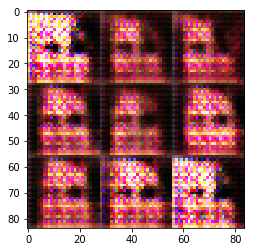

Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 2.1048
Epoch 1/1... Discriminator Loss: 0.7152... Generator Loss: 1.9629
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 1.5257
Epoch 1/1... Discriminator Loss: 1.6550... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 2.1931... Generator Loss: 0.2000
Epoch 1/1... Discriminator Loss: 0.3298... Generator Loss: 1.9905
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 2.3882... Generator Loss: 5.3361
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 0.8603


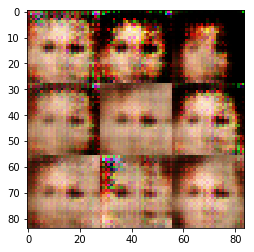

Epoch 1/1... Discriminator Loss: 1.9155... Generator Loss: 2.7635
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 0.7636


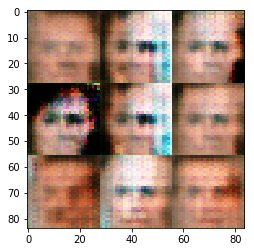

Epoch 1/1... Discriminator Loss: 1.8055... Generator Loss: 0.3212
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.4156
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 1.6148
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 1.8781
Epoch 1/1... Discriminator Loss: 1.7106... Generator Loss: 2.0405
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.2915


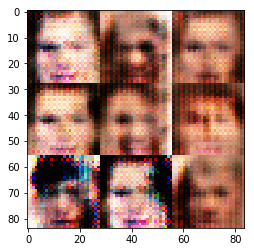

Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.5812
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.7332
Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.3970


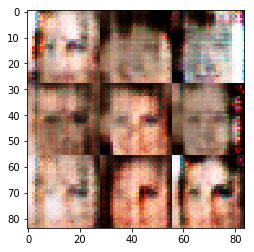

Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 1.6483
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.3901
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 2.2580
Epoch 1/1... Discriminator Loss: 2.9096... Generator Loss: 0.0907


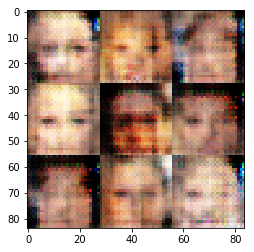

Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.2876
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 1.5618
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 3.1612
Epoch 1/1... Discriminator Loss: 2.3425... Generator Loss: 3.5780


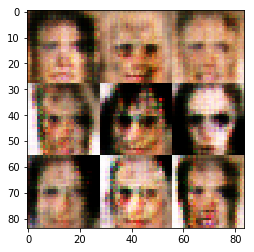

Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.7002... Generator Loss: 0.3763
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.6331
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.7536
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.6046
Epoch 1/1... Discriminator Loss: 1.7177... Generator Loss: 3.4390
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 2.1661
Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 0.9513
Epoch 1/1... Discriminator Loss: 2.7503... Generator Loss: 3.7722


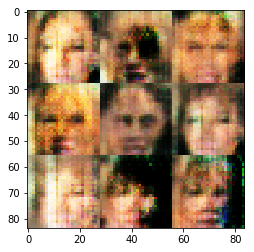

Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.7279
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 1.7922
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 2.1557... Generator Loss: 0.2411
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.6681
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 1.2593
Epoch 1/1... Discriminator Loss: 0.6395... Generator Loss: 1.8122
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.4484
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.6510


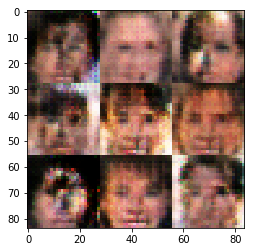

Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.6150
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 2.6366
Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.6748
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.8564... Generator Loss: 0.3452
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.6443
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 1.1449


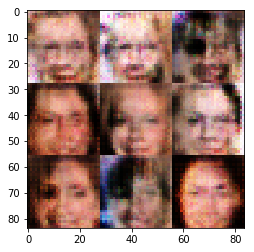

Epoch 1/1... Discriminator Loss: 2.1877... Generator Loss: 3.3459
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.6261
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.3110
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.7299
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 2.2678
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 0.4464
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.4596


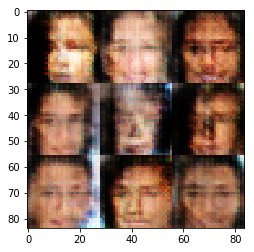

Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.6610... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.2708
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.1366
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.4338


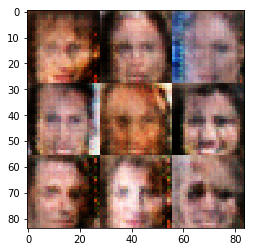

Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 1.6122
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 2.7837
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.6980
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.8252


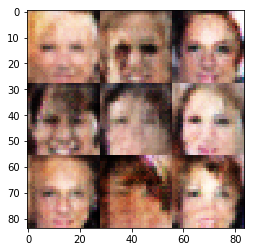

Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.3357
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 2.0710
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 1.0074


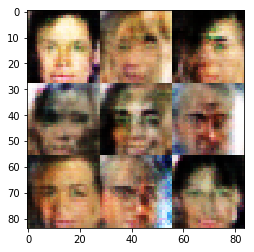

Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 1.7205... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 1.2586
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.4808


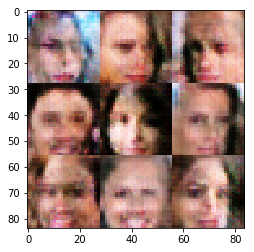

Epoch 1/1... Discriminator Loss: 1.6557... Generator Loss: 2.5166
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.6537
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 0.6840


In [184]:
batch_size = 128
z_dim = 100
learning_rate = 0.004
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.